# A Jupyter Notebook to aid Docking to MurD protein


This notebook implements a typical protocol for docking ligands to a target protein. It uses RDKit (http://www.rdkit.org) to generate a number of reasonable conformations for each ligand and then uses SMINA (https://sourceforge.net/projects/smina/) to do the docking. Two methods of docking are implemented, the first docks into a rigid receptor, the second sets the protein side-chains around the active site to be flexible. Bear in mind flexible docking will be much, much slower. In the optional final step the resulting docked poses are rescored using a random forest model described in https://www.nature.com/articles/srep46710.

In [34]:
import sys
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import pandas as pd
IPythonConsole.ipython_3d=True
%pylab inline

import py3Dmol

Populating the interactive namespace from numpy and matplotlib


## File location  of structures for docking and file format
First we need get the location of the input file of structures you want to dock, replace "asinexSelection.sdf" with your file. You may want to rename the output file for conformations, and the output file containing the docked structures.

The sdf file needs to have the name included in the first line of each molecule record.<br>

<code>AEM 10028511
  MOE2019           2D

 22 24  0  0  0  0  0  0  0  0999 V2000
    7.2040   -6.7290    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.3790   -6.7290    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0</code>

In [8]:
# File locations
sdfFilePath = 'asinexSelectionexport.sdf' # The input file of structures to generate conformations from
ConfoutputFilePath = 'asinexSelectionForDocking.sdf' # Output file containing conformations for docking

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

10

In [9]:
#Check that all molecules have a name
for i, mol in enumerate(inputMols):
    if mol is None:
        print('Warning: Failed to read molecule %s in %s' % (i, sdfFilePath))
    if not mol.GetProp('_Name'):

        print('Warning: No name for molecule %s in %s' % (i, sdfFilePath))

## Conformation generation
We next generate conformations, this uses paralellisation code from http://www.rdkit.org/docs/Cookbook.html contributed by Andrew Dalke. We don't use all cores on a desktop machine or it might be unresponsive. If running on a cluster you should modify this.

In [10]:
import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores -2

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time: 0:00:00 |################################|


In [11]:
ms = [x for x in Chem.SDMolSupplier(ConfoutputFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
for m in ms: Chem.AssignAtomChiralTagsFromStructure(m)
len(ms) # check how many conformations

43

## Docking to Protein
After generating the conformations we can now do the docking. In this example we use smina which can be downloaded from https://sourceforge.net/projects/smina/ you will need to know where smina has been installed.
The protein and ligand examples provided are taken from https://fragalysis.diamond.ac.uk/viewer/react/preview/target/MURD MURD-x0373.

Docking using smina<br>
Need protein minus the ligand in pdb format, <br>
the ligand extracted from binding site in pdb format, <br>
Conformations to be docked as sdf from conformation generation above<br>
DockedFilePath = 'All_Docked.sdf.gz' is the File for the Docked structures

In [12]:


ProteinForDocking = 'protein_minus_ligand.pdb'
LigandFromProtein = '373ligand_only.pdb'
DockedFilePath = 'All_Docked.sdf.gz'
FlexibleDockedFilePath = 'FlexDocked.sdf.gz'

In [13]:
!'/usr/local/bin/smina.osx' --cpu 10 --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' -o '{DockedFilePath}'


   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.8       0.000      0.000    
2       -5.5       2.150      3.452    
3       -5.3       4.201      8.009    
4       -5.3       2.249      3.595    
5       -4.9       3.191      4.088    
6       -4.8       1.074      1.280    
7       -4.7       5.563      6.404    
8       -4.5       2.441      3.553    
9       -4.5       3.472      6.748    
Refine time 8.813
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.5       0.000      0.000    
2       -5.3       1.458      2.016    
3       -5.3       2.002      2.718    
4       -4.9       1.64

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.9       0.000      0.000    
2       -5.8       2.538      7.374    
3       -5.7       2.830      7.585    
4       -5.7       1.955      2.747    
5       -5.6       2.190      3.060    
6       -5.2       3.447      8.188    
7       -5.1       1.458      7.546    
8       -5.1       2.641      4.252    
9       -4.8       2.932      5.756    
Refine time 16.686
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.2       0.000      0.000    
2       -6.1       2.342      3.158    
3       -6.0       2.784      4.461    
4       -5.9       2.2

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.9       0.000      0.000    
2       -5.9       1.873      2.456    
3       -5.9       2.736      7.260    
4       -5.8       2.875      4.898    
5       -5.6       1.514      2.173    
6       -5.5       1.306      1.928    
7       -5.4       2.903      7.145    
8       -5.2       2.662      6.754    
9       -4.8       4.631      6.788    
Refine time 11.063
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.8 

Flexible docking method, set all side chains within specified distance to flexdist_ligand to flexible
This will take an order of magnitude longer.
Currently disabled, to enable remove the #

In [24]:
#!'/usr/local/bin/smina.osx' --cpu 10 --seed 0 --autobox_ligand '{LigandFromProtein}'  --autobox_add 5 -r '{ProteinForDocking}' --flexres A:124,A:132,A:143,A:147,A:311,A:312,A:434,A:435 -l '{ConfoutputFilePath}' -o '{FlexibleDockedFilePath}'



## Rescoring using Random Forest Model

Optional, 
Rescore using a random forest model described in https://www.nature.com/articles/srep46710

Download from https://github.com/oddt/rfscorevs
You will need the path to the binary

Path to protein containing ligand in pdb format<br>
protein_plus_373ligand from Diamond<br>
File to store rescored results

In [14]:


TargetProtein = 'protein_plus_373ligand.pdb'
scoreResults = 'DockedRescored.csv'

In [15]:
!/usr/local/bin/rf-score-vs --receptor '{TargetProtein}' '{DockedFilePath}' -o csv -O '{scoreResults}' --field name --field RFScoreVS_v2

In [16]:

docked_df = PandasTools.LoadSDF(DockedFilePath,molColName='Molecule', removeHs=False)


,minimizedAffinity,ID,Molecule
0,-6.63499,ASN 13983556,
1,-6.39234,ASN 13983556,
2,-5.19878,ASN 13983556,
3,-5.12981,ASN 13983556,
4,-4.96488,ASN 13983556,

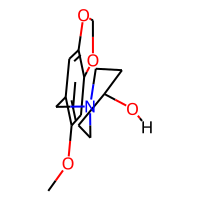
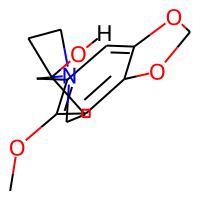
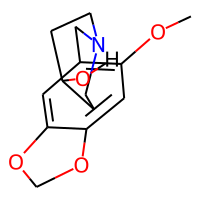
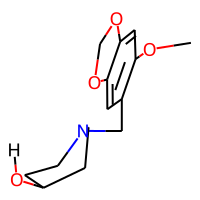
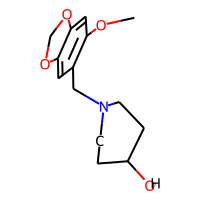

In [17]:
docked_df.head(n=5)

In [18]:
scores_df = pd.read_csv(scoreResults)

In [19]:
#scores_df.head(n=5)



In [20]:
results_df = pd.concat([docked_df, scores_df], axis=1)

,minimizedAffinity,ID,Molecule,name,RFScoreVS_v2
0,-6.63499,ASN 13983556,,ASN 13983556,6.128915
1,-6.39234,ASN 13983556,,ASN 13983556,6.115107
2,-5.19878,ASN 13983556,,ASN 13983556,6.067220
3,-5.12981,ASN 13983556,,ASN 13983556,6.128303
4,-4.96488,ASN 13983556,,ASN 13983556,6.093961

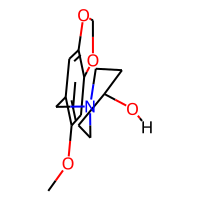
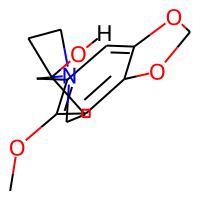
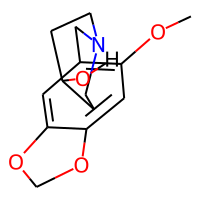
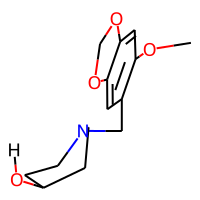
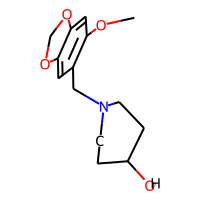

In [21]:
results_df.head(5)

## Saving the results
Now combine rescored file with docked structure file and export to "Alldata.sdf.gz" this is a big file so export compressed

In [22]:
combinedResults = 'Alldata.sdf.gz'

In [23]:
PandasTools.WriteSDF(results_df, combinedResults, molColName="Molecule", idName="ID", properties=list(results_df.columns))

,minimizedAffinity,ID,Molecule,name,RFScoreVS_v2
188,-4.10178,ASN 10790639,,ASN 10790639,6.274990
346,-7.22396,AEM 10028511,,AEM 10028511,6.253807
270,-4.49270,ART 13967891,,ART 13967891,6.253746
348,-6.68619,AEM 10028511,,AEM 10028511,6.253265
338,-7.34026,AEM 10028511,,AEM 10028511,6.243394

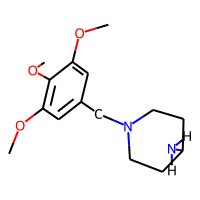
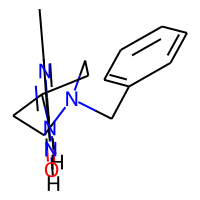
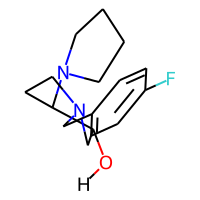
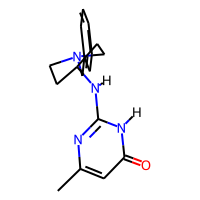
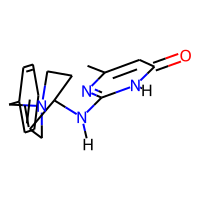

In [24]:
results_df.sort_values(["RFScoreVS_v2"], axis=0, ascending=False, inplace=True) #or sort by scoring function
results_df.head(5)

,minimizedAffinity,ID,Molecule,name,RFScoreVS_v2
336,-7.47479,AEM 10028511,,AEM 10028511,6.205563
372,-7.46385,AEM 10028511,,AEM 10028511,6.171796
337,-7.43328,AEM 10028511,,AEM 10028511,6.175466
373,-7.36845,AEM 10028511,,AEM 10028511,6.203558
338,-7.34026,AEM 10028511,,AEM 10028511,6.243394

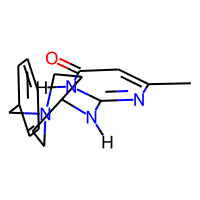
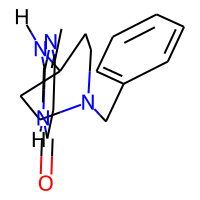
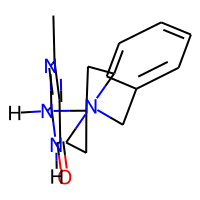
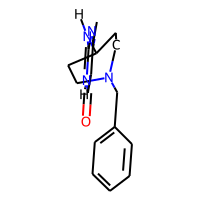
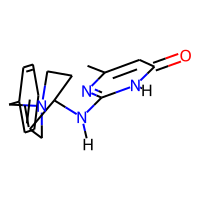

In [25]:
results_df.sort_values(["minimizedAffinity"], axis=0, ascending=False, inplace=True) #or sort by minimizedAffinity
results_df.head(5)

In [26]:
selectedPose = 'selectedpose.sdf'
selectedPoseH = 'selectedposeH.sdf'

# Export the top scoring molecules, edit "head(1)" to the number you want to export

In [27]:
PandasTools.WriteSDF(results_df.head(5), selectedPose, molColName="Molecule", idName="ID", properties=list(results_df.columns))

,minimizedAffinity,name,RFScoreVS_v2,ID,Molecule
0,-7.47479,AEM 10028511,6.205563,AEM 10028511,
1,-7.46385,AEM 10028511,6.171796,AEM 10028511,
2,-7.43328,AEM 10028511,6.175466,AEM 10028511,
3,-7.36845,AEM 10028511,6.203558,AEM 10028511,
4,-7.34026,AEM 10028511,6.243394,AEM 10028511,

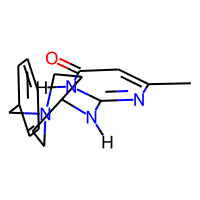
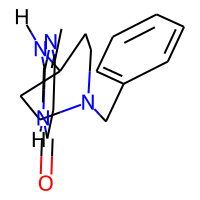
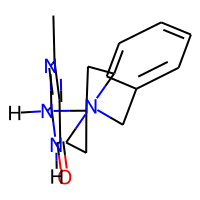
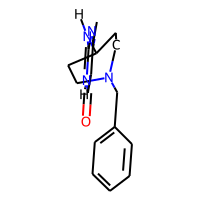
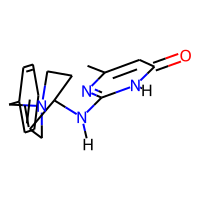

In [28]:
selecteddocked_df = PandasTools.LoadSDF(selectedPose,molColName='Molecule', removeHs=False)
selecteddocked_df

In [29]:
!obabel  -isdf 'selectedpose.sdf'  -osdf   -h  -O 'selectedposeH.sdf'

5 molecules converted


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

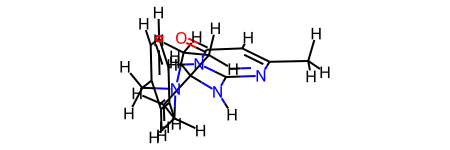

In [30]:
mH = Chem.MolFromMolFile(selectedPoseH, removeHs=False) #View first structure, Hydrogens present
mH

In [31]:
mols = [m for m in Chem.SDMolSupplier(selectedPoseH)]

In [32]:
def DrawDocking(protein,ligand):
     complex_pl = Chem.MolToPDBBlock(protein)
     docked_pdb = Chem.MolToPDBBlock(ligand)
     viewer = py3Dmol.view(width=800,height=800)
     viewer.addModel(complex_pl,'pdb')
     viewer.addModel(docked_pdb)
     prot = {'resn': ["DMS", "UNL", "SO4", "LIG", "HOH", "Cl"], 'invert': 1}  #define prot as all except list
     viewer.setStyle(prot,{'cartoon': {'colorscheme':'ssPyMol'}}) # Colour by secondary structure
     Lig_373 = {'resn' : 'LIG'} #original ligand in pdb file
     MyLig = {'resn':'UNL'} #ligand to be added from docking
     viewer.addSurface(py3Dmol.VDW,{'opacity':0.7, 'color': 'white'}, prot)
     viewer.setStyle({'resi': '132'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '147'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '311'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle(Lig_373,{'stick':{'colorscheme': 'whiteCarbon','radius':.1}}) 
     viewer.setStyle(MyLig,{'stick':{'colorscheme' : 'greenCarbon'}})
     viewer.zoomTo(MyLig)
     return viewer  

In [37]:
receptor = Chem.MolFromPDBFile(TargetProtein)
DrawDocking(receptor,mols[4])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol